In [1]:
class bcolors:
    OK = '\033[92m' #GREEN
    WARNING = '\033[93m' #YELLOW
    FAIL = '\033[91m' #RED
    RESET = '\033[0m' #RESET COLOR

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models
import matplotlib.pyplot as plt
import time
import os
import copy

import albumentations as A
from albumentations.pytorch import ToTensorV2

from math import ceil

import sys
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import seaborn as sns

print(f'{bcolors.OK}Enviroment setup complete!{bcolors.RESET}')

Enviroment setup complete!


In [3]:
writer = SummaryWriter('runs/Efficientnet_From_Scratch')

In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
print(f'{bcolors.OK}Sk Learn setup complete!{bcolors.RESET}')

Sk Learn setup complete!


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{bcolors.OK}{device}{bcolors.RESET}')

cuda:0


In [6]:
hyper_parameter = {
    "learning_rate": 0.001,
    "batch_size": 2,
    "num_workers": 2,
    "no_epochs": 15,
    "image_size": 256, 
    "in_channels": 3, 
    "num_classes": 8,
}

In [7]:
class Transforms:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']

In [8]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
hyper_parameter['image_size']=256

data_transforms = {
    'train': A.Compose([A.Resize(hyper_parameter['image_size'] , hyper_parameter['image_size']), A.Normalize(mean, std), ToTensorV2()]),
    'test': A.Compose([A.Resize(hyper_parameter['image_size'] , hyper_parameter['image_size']), A.Normalize(mean, std), ToTensorV2()])
}

In [9]:
data_dir = 'D:\sl\images'
sets = ['train', 'test']

In [10]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform =Transforms(transforms=data_transforms[x])) for x in ['train', 'test']}

In [11]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=hyper_parameter['batch_size'], shuffle=True) for x in ['train', 'test']}

In [12]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('train: {} test: {}'.format(dataset_sizes['train'], dataset_sizes['test']))
print(class_names)

train: 20265 test: 5066
['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']


In [13]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

torch.Size([2, 3, 256, 256])


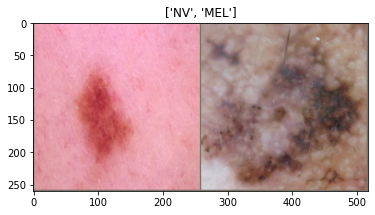

In [14]:
inputs, classes = next(iter(dataloaders['test']))
# print(inputs)
# print(classes)
print(inputs.size())
img_grid = torchvision.utils.make_grid(inputs)
writer.add_image('Cancer images', img_grid)
imshow(img_grid, title=[class_names[x] for x in classes])                    
writer.close()

In [15]:
def train_model(model, cirterion, optimizer, scheduler, num_epochs = 1):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  # best_sk_acc = 0.0
  best_f1_scr = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    print('-' * 15)

    for phase in ['train', 'test']:
      if phase =='train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      real_targets = []
      predicted_targets = []

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        # track history only if train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          

          real_targets.extend(labels.detach().cpu().numpy())
          predicted_targets.extend(preds.detach().cpu().numpy())

          loss = cirterion(outputs, labels)

          #backward + optimize only if in train
          if phase == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      
      if phase == 'train':
        scheduler.step()

      # sk_epoch_acc = accuracy_score(predicted_targets, real_targets)
      sk_f1 = f1_score(predicted_targets, real_targets, average='micro')

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects / dataset_sizes[phase]

      # printing epoch resutlts
      print(f'{phase} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')
      print(f'{phase} F1 Score: {sk_f1:.4f}')
      epoch_time = time.time() - since
      print(f'Epoch time: {epoch_time // 60:.0f}m {epoch_time %  60:.0f}s')

      if phase == 'test' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

      # if phase == 'test' and sk_epoch_acc > best_sk_acc:
      #   best_sk_acc = sk_epoch_acc
      #   best_model_wts = copy.deepcopy(model.state_dict())
      
      
      if phase == 'test' and sk_f1 > best_f1_scr:
        best_f1_scr = sk_f1

    print()
  
  # printing time require to train model
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m { time_elapsed % 60:.0f}s')

  t = time.localtime()
  current_time = time.strftime("%H:%M", t)
  print(f'Trainig completed at {current_time}')
  print(f'Best val Acc: {best_acc:4f}')
  # print(f'Best sk Acc: {best_sk_acc:4f}')
  print(f'Best sk F1 : {best_f1_scr:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [16]:
base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)

In [17]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    
    def forward(self, x):
        return x

In [18]:
class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )

    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4*ceil(int(channels*width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        x = self.pool(self.features(x))
        return self.classifier(x.view(x.shape[0], -1))

In [19]:
def test():
    version = "b0"
    phi, res, drop_rate = phi_values[version]
    num_examples, num_classes = 4, 10
    x = torch.randn((num_examples, 3, res, res)).to(device)
    model = EfficientNet(
        version=version,
        num_classes=num_classes,
    ).to(device)

    print(model(x).shape) # (num_examples, num_classes)

test()

torch.Size([4, 10])


In [20]:
version = "b0"
model = EfficientNet(version=version, num_classes=hyper_parameter['num_classes'])
print(model.parameters)

<bound method Module.parameters of EfficientNet(
  (pool): AdaptiveAvgPool2d(output_size=1)
  (features): Sequential(
    (0): CNNBlock(
      (cnn): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (silu): SiLU()
    )
    (1): InvertedResidualBlock(
      (conv): Sequential(
        (0): CNNBlock(
          (cnn): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (silu): SiLU()
        )
        (1): SqueezeExcitation(
          (se): Sequential(
            (0): AdaptiveAvgPool2d(output_size=1)
            (1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (2): SiLU()
            (3): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (4): Sigmoid()
          )
        )
        (2): Conv2d(3

In [21]:
model.to(device)

next(model.parameters()).device

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = hyper_parameter['learning_rate'])

# scheduler
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=hyper_parameter['no_epochs'])

Epoch 1/15
---------------
train Loss: 1.4765, Acc: 0.5063
train F1 Score: 0.5063
Epoch time: 57m 47s
test Loss: 1.4804, Acc: 0.5024
test F1 Score: 0.5024
Epoch time: 62m 32s

Epoch 2/15
---------------
train Loss: 1.4211, Acc: 0.5085
train F1 Score: 0.5085
Epoch time: 120m 17s
test Loss: 1.3570, Acc: 0.5101
test F1 Score: 0.5101
Epoch time: 125m 10s

Epoch 3/15
---------------
train Loss: 1.3256, Acc: 0.5284
train F1 Score: 0.5284
Epoch time: 183m 9s
test Loss: 1.2991, Acc: 0.5436
test F1 Score: 0.5436
Epoch time: 188m 3s

Epoch 4/15
---------------
train Loss: 1.2543, Acc: 0.5578
train F1 Score: 0.5578
Epoch time: 245m 43s
test Loss: 1.2510, Acc: 0.5584
test F1 Score: 0.5584
Epoch time: 250m 32s

Epoch 5/15
---------------
train Loss: 1.2011, Acc: 0.5766
train F1 Score: 0.5766
Epoch time: 307m 35s
test Loss: 1.1675, Acc: 0.5859
test F1 Score: 0.5859
Epoch time: 312m 43s

Epoch 6/15
---------------
train Loss: 1.1604, Acc: 0.5927
train F1 Score: 0.5927
Epoch time: 372m 49s
test Loss: 

In [22]:
testloader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=4, shuffle=True)

real_targets = []
predicted_targets = []

inputs, labels = next(iter(testloader))
inputs = inputs.to(device)
labels = labels.to(device)
# print(inputs)
# print(labels)

outputs = model(inputs)
_, preds = torch.max(outputs, 1)
# print(outputs)
# print(preds)

real_targets.extend(labels.detach().cpu().numpy())
predicted_targets.extend(preds.detach().cpu().numpy())
print(real_targets)
print(predicted_targets)

test_cf_mat = confusion_matrix(predicted_targets, real_targets)
test_f1 = f1_score(predicted_targets, real_targets, average='micro')


print(f'F1 Score: {test_f1}')
print(f'Confusion Mat: \n {test_cf_mat}')

[4, 2, 4, 1]
[5, 5, 4, 5]
F1 Score: 0.25
Confusion Mat: 
 [[0 0 0 0]
 [0 0 0 0]
 [0 0 1 0]
 [1 1 1 0]]
